### Generate JCM Default Statistics

This notebook is used to generate the statistics (mean and std deviation) used in the model unit test model_test.py:test_speedy_model_default_statistics(). If the model behavior changes meaningfully we will want to rerun these and generate a new default_statistics.nc file.

In [1]:
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu" # for use on ARM Macs

import jax
print("JAX device:", jax.devices())
jax.config.update('jax_disable_jit', False) # Turn off JIT because of an issue in shortwave_radiation.py:169
jax.config.update("jax_debug_infs", True) # doesn't add any time since the saved time is otherwise spent getting the nodal quantities
jax.config.update("jax_debug_nans", False) # some physics fields might be nan

Metal device set to: Apple M3 Max

systemMemory: 36.00 GB
maxCacheSize: 13.50 GB

JAX device: [CpuDevice(id=0)]


W0000 00:00:1761839103.674101 9077769 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1761839103.684761 9077769 service.cc:145] XLA service 0x10e5bd480 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761839103.684770 9077769 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1761839103.685834 9077769 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1761839103.685842 9077769 mps_client.cc:384] XLA backend will use up to 28990554112 bytes on device 0 for SimpleAllocator.


In [2]:
from jcm.model import Model, get_coords
from jcm.boundaries import boundaries_from_file

realistic_boundaries = boundaries_from_file(
    'jcm/data/bc/t30/clim/boundaries_daily.nc',
    get_coords().horizontal,
)

In [3]:
# default model settings
# use reslistic orography from boundaries file
model = Model(
    orography=realistic_boundaries.orog,
    time_step=60.,
)

# save every month, run for several months, turn on averaging so that the last diagnostic is averages of the last month
predictions = model.run(
    save_interval=60./1440.,
    total_time=90,
    output_averages=True,
    boundaries=realistic_boundaries,
)

In [4]:
pred_ds = model.predictions_to_xarray(predictions)

In [5]:
nTimeSteps = 24*30 # take mean and std deviation over the last 30 days

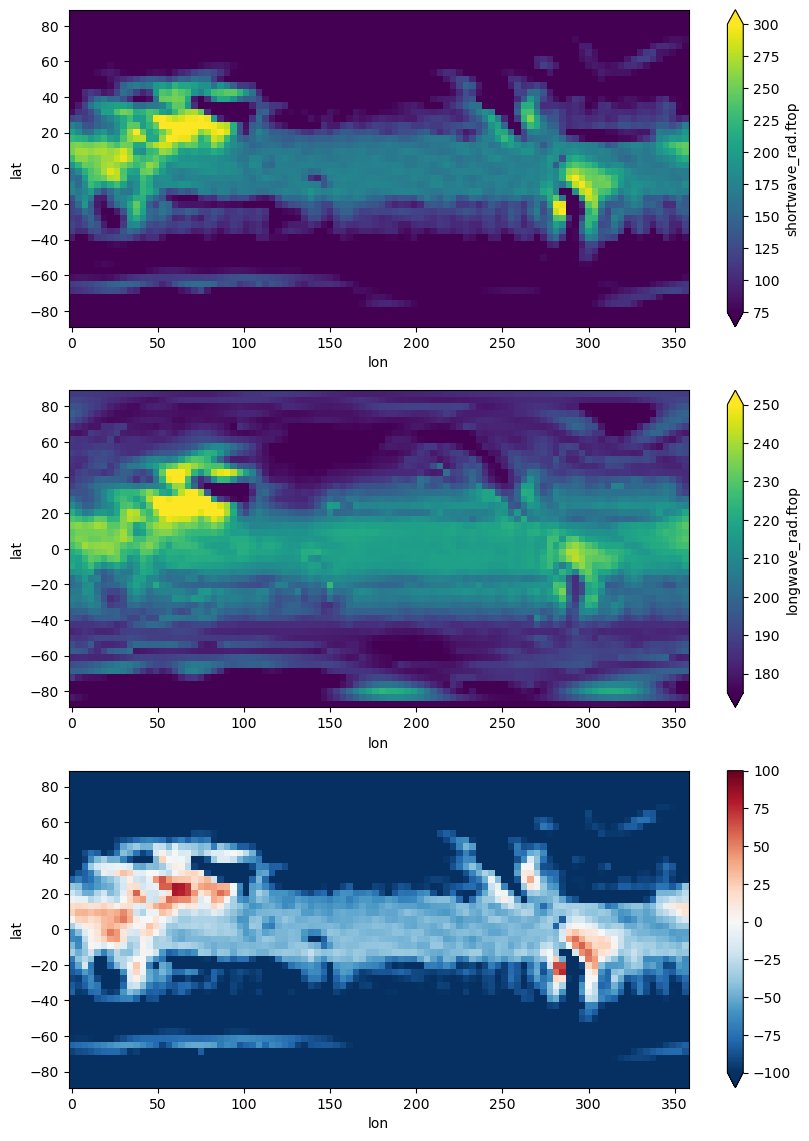

In [6]:
import matplotlib.pyplot as plt 
fig, ax = plt.subplots(nrows=3, figsize=(10,14))
pred_ds['shortwave_rad.ftop'].isel(time=slice(-nTimeSteps,None)).mean(dim='time').T.plot(ax=ax[0],vmin=75,vmax=300)
pred_ds['longwave_rad.ftop'].isel(time=slice(-nTimeSteps,None)).mean(dim='time').T.plot(ax=ax[1],vmin=175,vmax=250)
(pred_ds['shortwave_rad.ftop']-pred_ds['longwave_rad.ftop']).isel(time=slice(-nTimeSteps,None)).mean(dim='time').T.plot(ax=ax[2],cmap='RdBu_r',vmin=-100,vmax=100)

#### Save to netCDF

In [7]:
import xarray as xr
# generate maps of means and variances for the last 30 days of the run, add floating pt precision to std deviations (in case they are 0)
eps = 0

q_mean = pred_ds.isel(time=slice(-nTimeSteps,None)).specific_humidity.mean(dim='lon').mean(dim='time')
q_std = pred_ds.isel(time=slice(-nTimeSteps,None)).specific_humidity.mean(dim='lon').std(dim='time') + eps

t_mean = pred_ds.isel(time=slice(-nTimeSteps,None)).temperature.mean(dim='lon').mean(dim='time')
t_std = pred_ds.isel(time=slice(-nTimeSteps,None)).temperature.mean(dim='lon').std(dim='time') + eps

u_mean = pred_ds.isel(time=slice(-nTimeSteps,None)).u_wind.mean(dim='lon').mean(dim='time')
u_std = pred_ds.isel(time=slice(-nTimeSteps,None)).u_wind.mean(dim='lon').std(dim='time') + eps

v_mean = pred_ds.isel(time=slice(-nTimeSteps,None)).v_wind.mean(dim='lon').mean(dim='time')
v_std = pred_ds.isel(time=slice(-nTimeSteps,None)).v_wind.mean(dim='lon').std(dim='time') + eps

nsp_mean = pred_ds.isel(time=slice(-nTimeSteps,None)).normalized_surface_pressure.mean(dim='lon').mean(dim='time')
nsp_std = pred_ds.isel(time=slice(-nTimeSteps,None)).normalized_surface_pressure.mean(dim='lon').std(dim='time') + eps

phi_mean = pred_ds.isel(time=slice(-nTimeSteps,None)).geopotential.mean(dim='lon').mean(dim='time')
phi_std = pred_ds.isel(time=slice(-nTimeSteps,None)).geopotential.mean(dim='lon').std(dim='time') + eps

# total outgoing radiation at top of atmosphere
TOA_rad = pred_ds['shortwave_rad.ftop']-pred_ds['longwave_rad.ftop']
TOA_rad_mean = TOA_rad.isel(time=slice(-nTimeSteps,None)).mean(dim='lon').mean(dim='time')
TOA_rad_std = TOA_rad.isel(time=slice(-nTimeSteps,None)).mean(dim='lon').std(dim='time') + eps

# relative humidity
rh_mean = pred_ds['humidity.rh'].isel(time=slice(-nTimeSteps,None)).mean(dim='lon').mean(dim='time')
rh_std = pred_ds['humidity.rh'].isel(time=slice(-nTimeSteps,None)).mean(dim='lon').std(dim='time') + eps

# stratiform cloud cover
cloudstr_mean = pred_ds['shortwave_rad.cloudstr'].isel(time=slice(-nTimeSteps,None)).mean(dim='lon').mean(dim='time')
cloudstr_std = pred_ds['shortwave_rad.cloudstr'].isel(time=slice(-nTimeSteps,None)).mean(dim='lon').std(dim='time') + eps

# equivalent specific humidity of clouds
qcloud_mean = pred_ds['shortwave_rad.qcloud'].isel(time=slice(-nTimeSteps,None)).mean(dim='lon').mean(dim='time')
qcloud_std = pred_ds['shortwave_rad.qcloud'].isel(time=slice(-nTimeSteps,None)).mean(dim='lon').std(dim='time') + eps

# precip from convection
precnv_mean = pred_ds['convection.precnv'].isel(time=slice(-nTimeSteps,None)).mean(dim='lon').mean(dim='time')
precnv_std = pred_ds['convection.precnv'].isel(time=slice(-nTimeSteps,None)).mean(dim='lon').std(dim='time') + eps

# precip from large scale condensation
precls_mean = pred_ds['condensation.precls'].isel(time=slice(-nTimeSteps,None)).mean(dim='lon').mean(dim='time')
precls_std = pred_ds['condensation.precls'].isel(time=slice(-nTimeSteps,None)).mean(dim='lon').std(dim='time') + eps

ds = xr.Dataset({"q_mean": q_mean, "q_std": q_std,
                "t_mean": t_mean, "t_std": t_std,
                "u_mean": u_mean, "u_std": u_std,
                "v_mean": v_mean, "v_std": v_std,
                "nsp_mean": nsp_mean, "nsp_std": nsp_std,
                "phi_mean": phi_mean, "phi_std": phi_std,
                "TOA_rad_mean": TOA_rad_mean, "TOA_rad_std": TOA_rad_std,
                "rh_mean": rh_mean, "rh_std": rh_std,
                "cloudstr_mean": cloudstr_mean, "cloudstr_std": cloudstr_std,
                "qcloud_mean": qcloud_mean, "qcloud_std": qcloud_std,
                "precnv_mean": precnv_mean, "precnv_std": precnv_std,
                "precls_mean": precls_mean, "precls_std": precls_std
                })

ds.to_netcdf('jcm/data/test/t30/default_statistics.nc')
